In [1]:
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.display import Image

In [2]:
import pymuqUtilities as mu
from pymuqUtilities import RandomGenerator as rg

import pymuqModeling as mm
import pymuqSamplingAlgorithms as ms # Needed for MCMC


## Define the transformation
$$
z = \left[\begin{array}{c} z_1 \\ z_2 \end{array} \right] = T(m) = \left[\begin{array}{l} \frac{1}{a} m_1 \\ a m_2 + ab( cos(m_1) + a^2) \end{array}\right].
$$


In [3]:
class InvBananaTrans(mm.PyModPiece):
    """ This defines the inverse transform T(m) defined in the equations above. """
    
    def __init__(self, a, b):
        mm.PyModPiece.__init__(self, [2], # One input containing 2 components
                                     [2]) # One output containing 2 components
        self.a = a
        self.b = b
        print(self.a)
        
    def EvaluateImpl(self, inputs):
        m = inputs[0]
        
        z = np.zeros((2))
        z[0] = m[0]/self.a
        z[1] = m[1]*self.a + self.a*self.b*(m[0]**2 + self.a**2)
        self.outputs = [z]

In [4]:
paramDim = 2
a = 1.0
b = 1.0

invf = InvBananaTrans(a,b)
zDist = mm.Gaussian(np.zeros((paramDim)))

1.0


In [5]:
graph = mm.WorkGraph()

graph.AddNode(zDist.AsDensity(), "Gaussian Reference")
graph.AddNode(invf, "Banana Transformation")

graph.AddEdge("Banana Transformation", 0, "Gaussian Reference", 0)

In [6]:
tgtDens = graph.CreateModPiece("Gaussian Reference")

In [63]:
# problem = ms.SamplingProblem(tgtDens)
laOptions = dict()

laOptions['RegressionOptions'] = 'MyRegression'
laOptions['MyRegression.NumNeighbors'] = 10
laOptions['MyRegression.Order'] = 2
laOptions['GammaScale'] = 2.0
laOptions['GammaExponent'] = 1.0

# These options are needed when the tails are long
laOptions['LyapunovScale'] = 0.05
laOptions['LyapunovExponent'] = 1.0
laOptions['TailCorrection'] = 1e-7

problem = ms.ExpensiveSamplingProblem(tgtDens, laOptions)

#problem = ms.SamplingProblem(tgtDens)

In [64]:
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 2.0
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 2.0

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 10000
options['ThinIncrement'] = 1
options['BurnIn'] = 0
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [65]:
startPt = np.zeros(2)
samps = mcmc.Run([startPt])

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 38%
  20% Complete
    Block 0:
      Acceptance Rate = 32%
  30% Complete
    Block 0:
      Acceptance Rate = 30%
  40% Complete
    Block 0:
      Acceptance Rate = 28%
  50% Complete
    Block 0:
      Acceptance Rate = 28%
  60% Complete
    Block 0:
      Acceptance Rate = 27%
  70% Complete
    Block 0:
      Acceptance Rate = 27%
  80% Complete
    Block 0:
      Acceptance Rate = 27%
  90% Complete
    Block 0:
      Acceptance Rate = 27%
  100% Complete
    Block 0:
      Acceptance Rate = 27%
Completed in 7.44543 seconds.


In [66]:
sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)


Sample mean = 
 [ 0.0692915  -2.03671455]

Sample Covariance = 
 [[ 1.04922138 -0.29419474]
 [-0.29419474  3.17457017]]


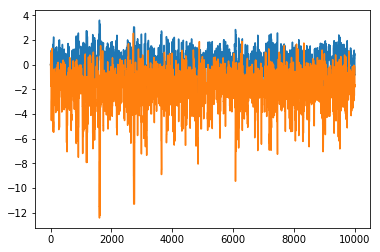

In [67]:
sampMat = samps.AsMatrix()
plt.plot(sampMat.T);

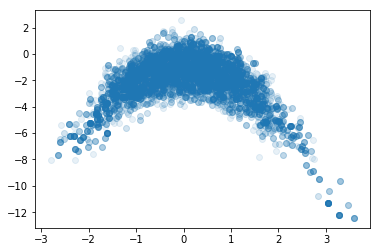

In [68]:
plt.scatter(sampMat[0,:],sampMat[1,:],alpha=0.1)

The target density was evaluated 29795 times.



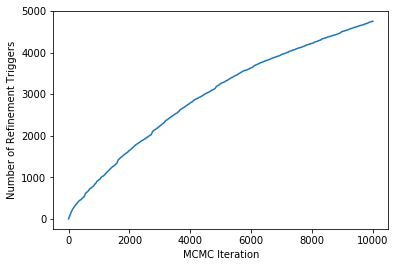

In [69]:
numRefines = samps.GetMeta('cumulative structural refinement')[0,:]
print('The target density was evaluated %d times.'%tgtDens.GetNumCalls('Evaluate'))
print()

plt.plot(numRefines);
plt.ylabel('Number of Refinement Triggers')
plt.xlabel('MCMC Iteration');